<a href="https://colab.research.google.com/github/tmshariful/News_Popularity_Analysis/blob/main/News_sentiment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading the csv data to a Pandas DataFrame
news_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Heart Disease/News_Final.csv')

In [ ]:
news_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [ ]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             93239 non-null  float64
 1   Title              93239 non-null  object 
 2   Headline           93224 non-null  object 
 3   Source             92960 non-null  object 
 4   Topic              93239 non-null  object 
 5   PublishDate        93239 non-null  object 
 6   SentimentTitle     93239 non-null  float64
 7   SentimentHeadline  93239 non-null  float64
 8   Facebook           93239 non-null  int64  
 9   GooglePlus         93239 non-null  int64  
 10  LinkedIn           93239 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.8+ MB


In [ ]:
news_data.shape

(93239, 11)

In [ ]:
news_data.loc[0,'Headline']

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

In [ ]:
news_data.loc[0,'Title']

'Obama Lays Wreath at Arlington National Cemetery'

In [ ]:
news_data[news_data['Source'].isna()]

In [ ]:
missing_val = pd.DataFrame(news_data.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,15
3,Source,279
4,Topic,0
5,PublishDate,0
6,SentimentTitle,0
7,SentimentHeadline,0
8,Facebook,0
9,GooglePlus,0


In [ ]:
news_data.dropna(inplace=True)

In [ ]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92945 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             92945 non-null  float64
 1   Title              92945 non-null  object 
 2   Headline           92945 non-null  object 
 3   Source             92945 non-null  object 
 4   Topic              92945 non-null  object 
 5   PublishDate        92945 non-null  object 
 6   SentimentTitle     92945 non-null  float64
 7   SentimentHeadline  92945 non-null  float64
 8   Facebook           92945 non-null  int64  
 9   GooglePlus         92945 non-null  int64  
 10  LinkedIn           92945 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 8.5+ MB


In [ ]:
news_data.describe().T

,count,mean,std,min,25%,50%,75%,max
IDLink,92945.0,51488.725537,30391.373770,1.000000,24240.000000,52159.000000,76489.000000,104802.000000
SentimentTitle,92945.0,-0.005326,0.136501,-0.950694,-0.079057,0.000000,0.064892,0.962354
SentimentHeadline,92945.0,-0.027490,0.142063,-0.755433,-0.114598,-0.026064,0.059868,0.964646
Facebook,92945.0,113.497897,621.120839,-1.000000,0.000000,5.000000,33.000000,49211.000000
GooglePlus,92945.0,3.901124,18.520443,-1.000000,0.000000,0.000000,2.000000,1267.000000
LinkedIn,92945.0,16.600882,154.700274,-1.000000,0.000000,0.000000,4.000000,20341.000000


In [ ]:
news_data['Topic'].value_counts()

economy      33889
obama        28598
microsoft    21851
palestine     8607
Name: Topic, dtype: int64

In [ ]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['Palestinian','Palestine','Microsoft','Economy','Obama','Barack'])

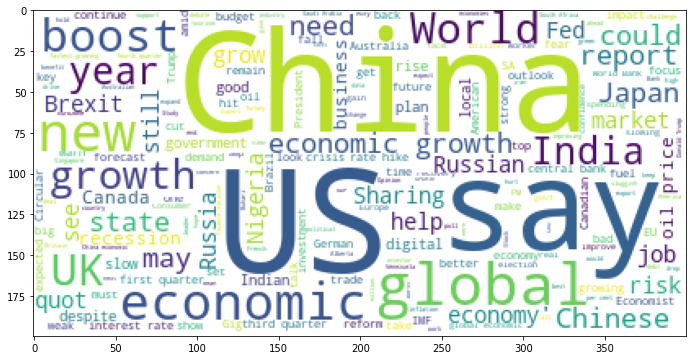

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(news_data.Title[news_data['Topic']=='economy'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

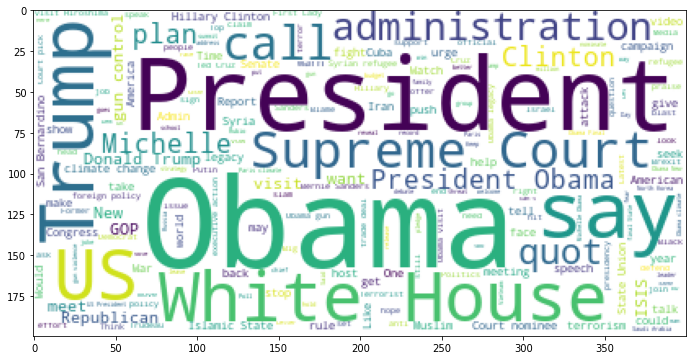

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(news_data.Title[news_data['Topic']=='obama'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

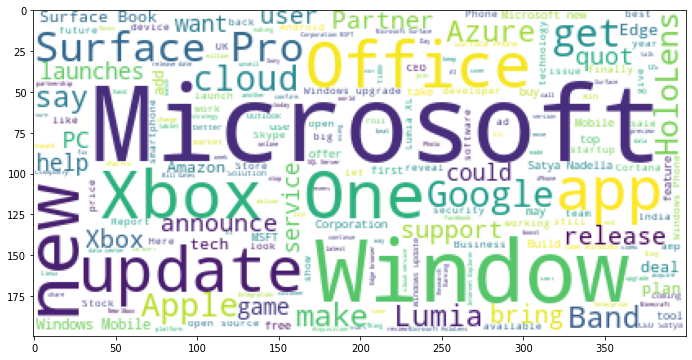

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(news_data.Title[news_data['Topic']=='microsoft'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

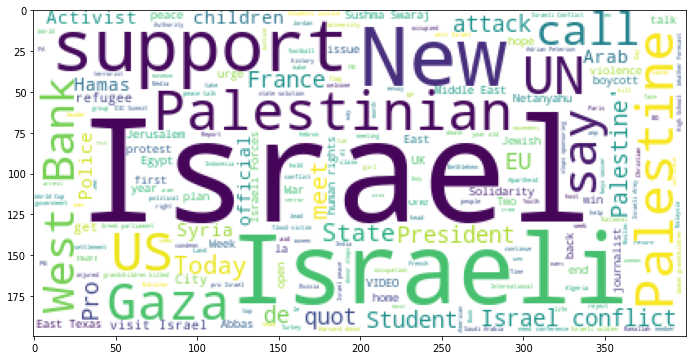

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(news_data.Title[news_data['Topic']=='palestine'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

In [ ]:
sns.set(style='darkgrid',palette='Set1')

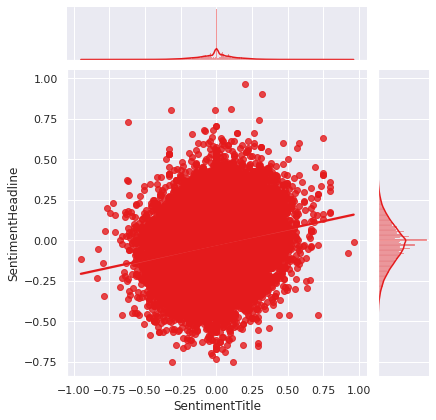

In [ ]:
_ = sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=news_data,kind = 'reg')

plt.show()

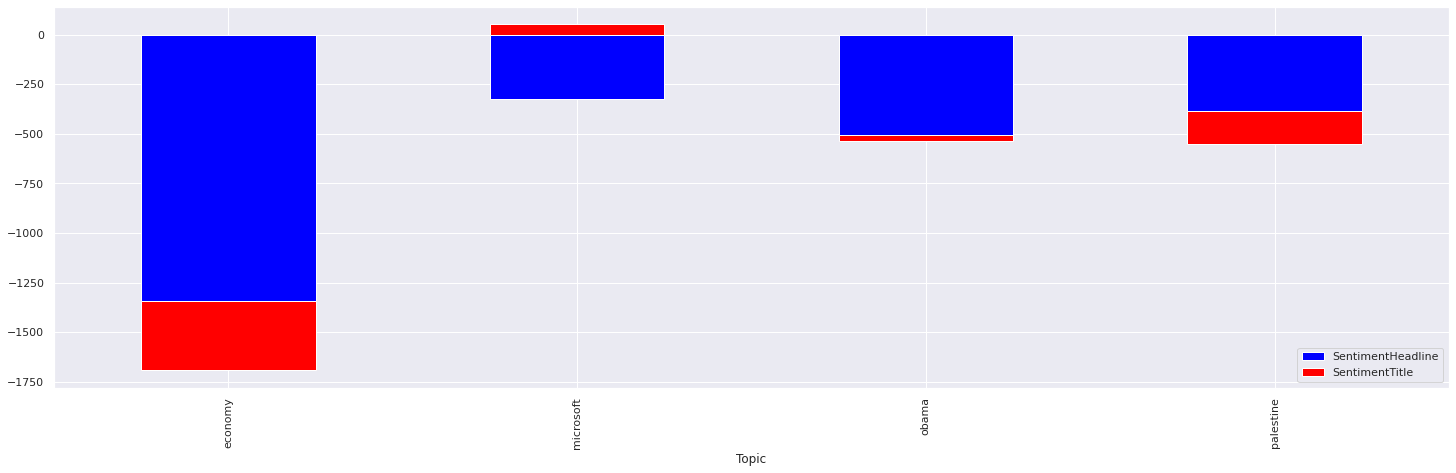

In [ ]:
# Bar graph exploring total sentiment for the different topics

news_data.groupby('Topic').agg('sum')[['SentimentHeadline', 'SentimentTitle']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r', 'g']);

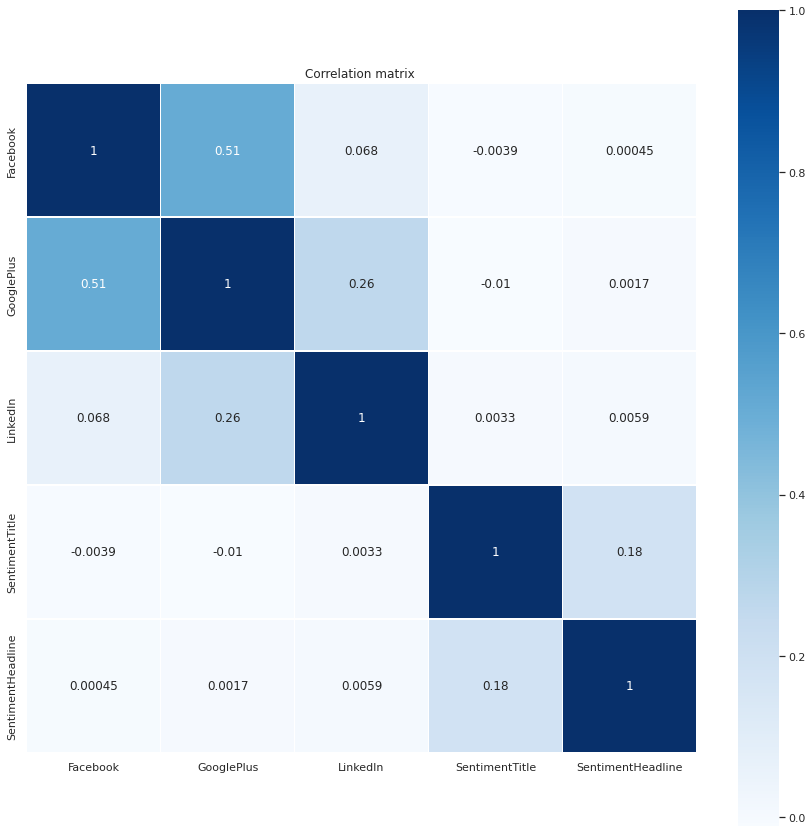

In [ ]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(news_data[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True, cmap='Blues',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [ ]:
nlp = English()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import string
stop_words=STOP_WORDS
punctuations=string.punctuation
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # here the token is converted into lowercase if it is a Pronoun and if it is not a Pronoun then it is lemmatized and lowercased    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words using stopword from spacy library and punctuations from string library
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
from sklearn.base import TransformerMixin
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]

    def fit(self, X, y, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
   
    return text.strip().lower()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vector = CountVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

In [ ]:
X_train_title = news_data.loc[:,'Title'].values
y_train_title = news_data.loc[:,['SentimentTitle']].values

X_train_headline = news_data.loc[:,'Headline'].values
y_train_headline = news_data.loc[:,['SentimentHeadline']].values

In [ ]:
X_train_title

array(['Obama Lays Wreath at Arlington National Cemetery',
       'A Look at the Health of the Chinese Economy',
       'Nouriel Roubini: Global Economy Not Back to 2008', ...,
       "Palestinian Government Uses Foreign Aid To Pay Terrorists' Salaries",
       'Palestine Youth Orchestra prepares for first UK tour',
       'Sausalito businesswoman wins $10000 in Microsoft Windows 10 ...'],
      dtype=object)

In [ ]:
X_train_title.shape

(92945,)

In [ ]:
y_train_headline.shape

(92945, 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(X_train_title, y_train_title, shuffle = True, test_size = 0.25)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(X_train_headline, y_train_headline, shuffle = True, test_size = 0.25)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
xgboost = MultiOutputRegressor(XGBRegressor())
rand_for = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=None,
                                                          random_state=0))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
pipe_title = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for)])

pipe_headline = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for)])

In [ ]:
pipe_title.fit(x_train_title,Y_train_title)

KeyboardInterrupt: ignored

In [ ]:
pipe_headline.fit(x_train_headline,Y_train_headline)

In [ ]:
test_pred_title=pipe_title.predict(x_valid_title)

In [ ]:
test_pred_headline=pipe_headline.predict(x_valid_headline)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_title=mean_absolute_error(y_valid_title,test_pred_title)
mae_headline=mean_absolute_error(y_valid_headline,test_pred_headline)

In [ ]:
score=1-((0.4*mae_title)+(0.6*mae_headline))

In [ ]:
print("Score = {} \nScore(out of 100%) = {}%".format(score,score*100))